In [1]:
import pandas as pd

In [2]:
logs = pd.read_json("/Users/chenghao/log.json")
stats = pd.read_csv("/Users/chenghao/stats.csv")

In [3]:
from pprint import pprint

pprint(logs.iloc[0].to_dict())

{'done': True,
 'driverControlFilesUri': 'gs://dataproc-staging-us-central1-15650476249-ih5yw8lm/google-cloud-dataproc-metainfo/f4e62156-cad0-4750-84d8-f91ebcc03f63/jobs/3adec77a858142f989be9271b12d2393/',
 'driverOutputResourceUri': 'gs://dataproc-staging-us-central1-15650476249-ih5yw8lm/google-cloud-dataproc-metainfo/f4e62156-cad0-4750-84d8-f91ebcc03f63/jobs/3adec77a858142f989be9271b12d2393/driveroutput',
 'jobType': 'pyspark',
 'jobUuid': '4f921100-8cfa-3c77-bffe-01569787b429',
 'labels': {'round': '1'},
 'placement': {'clusterName': 'chenghao-temp',
               'clusterUuid': 'f4e62156-cad0-4750-84d8-f91ebcc03f63'},
 'pysparkJob': {'args': ['--table',
                         'huggingface-science-codeparrot.the_stack_v1_2.omgrofl',
                         '--output',
                         'gs://the_stack_v1_2_dedup/omgrofl'],
                'jarFileUris': ['gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar'],
                'loggingConfig': {'driverLogLevels': {'root'

In [4]:
import datetime

def process_log(record):
    lan = record["pysparkJob"]['args'][1].split('.')[-1]
    end_time = record["status"]['stateStartTime']
    start_time = record["statusHistory"][-1]['stateStartTime']
    return {
        "lan": lan,
        "delta": (pd.to_datetime(end_time) - pd.to_datetime(start_time)).total_seconds(),
    }


times = pd.json_normalize(logs.apply(process_log, axis=1))

In [5]:
times

,lan,delta
0,omgrofl,32.100511
1,numpy,32.743797
2,omgrofl,28.667411
3,numpy,31.549284
4,zimpl,46.127168
...,...,...
360,agda,81.600973
361,ada,81.476939
362,actionscript,87.176404
363,abap,75.498094


In [6]:
all_stats = pd.merge(
    times.groupby("lan").mean().reset_index().rename(columns={"lan": "table_id", "delta": "time"}),
    stats,
    on="table_id",
)
all_stats.head()

,table_id,time,size_before_gb,size_after_gb,row_before,row_after,delta_size_percentage,delta_row_percentage
0,abap,75.498094,0.25,0.09,23512,12161,65.33,48.28
1,actionscript,87.176404,1.39,0.71,215655,136143,48.78,36.87
2,ada,81.476939,0.96,0.32,60325,31291,66.94,48.13
3,agda,81.600973,0.14,0.09,24996,17608,34.20,29.56
4,ags-script,61.482153,0.02,0.01,2004,1061,60.19,47.06


In [7]:
all_stats = all_stats[all_stats["time"].notna()]
len(all_stats)

360

In [9]:
all_stats = all_stats.sort_values("time", ascending=False)
partial_stats = all_stats.iloc[2:]

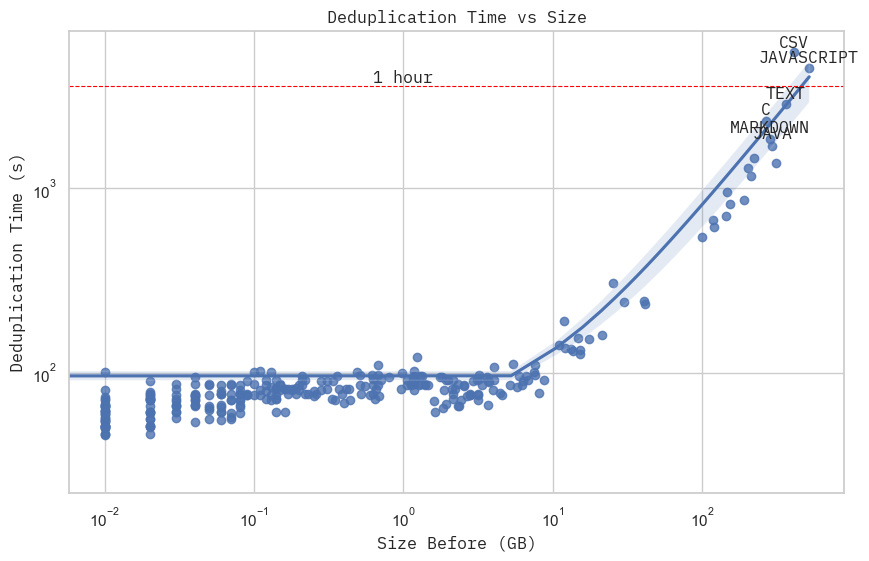

In [22]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams

# set font
fpath = os.path.join("/Users/chenghao/Library/Fonts/IBMPlexMono-Regular.ttf")
prop = fm.FontProperties(fname=fpath)
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=partial_stats, x="size_before_gb", y="time", ax=ax)
# sns.regplot(data=all_stats, x="row_before", y="time", ax=ax)
ax.set_xlabel("Size Before (GB)", fontproperties=prop)
ax.set_ylabel("Deduplication Time (s)", fontproperties=prop)
ax.set_title("Deduplication Time vs Size", fontproperties=prop)

ax.axhline(3600, color="red", linewidth=0.8, linestyle="--")
ax.text(1, 3600, "1 hour", fontproperties=prop, ha="center", va="bottom")
plt.xscale('log')
plt.yscale('log')
for lan in partial_stats.sort_values("time", ascending=False)[:6].to_dict("records"):
    name = lan["table_id"]
    size = lan["size_before_gb"]
    time = lan["time"]
    ax.text(size, time + 90, name.upper(), fontproperties=prop, ha="center", va="bottom")